In [1]:
import torch
import torchvision

from models import LFADS
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

np = torch._np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


In [3]:
seed = 250
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    data_dict = generate_lorenz_data(N_cells=30, N_inits=65, N_trials=20, N_steps=200, N_stepsinbin=2, dt_lorenz=0.015, dt_spike = 1./20, base_firing_rate= 1.0, save=True, seed=250)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('./parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] += '_localtest'
save_parameters(hyperparams, path=None)

hyperparams

{'betas': (0.9, 0.99),
 'clip_val': 5.0,
 'dataset_name': 'lorenz',
 'datatype': 'spikes',
 'epsilon': 0.1,
 'factors_dim': 3,
 'g0_encoder_dim': 64,
 'g0_prior_kappa': 0.1,
 'g0_prior_var_max': 0.1,
 'g0_prior_var_min': 0.1,
 'g_dim': 64,
 'keep_prob': 0.95,
 'kernel_dim': 20,
 'kl_weight_min': 0.0,
 'kl_weight_schedule_dur': 1600,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 250,
 'l2_weight_min': 0.0,
 'l2_weight_schedule_dur': 1600,
 'l2_weight_schedule_start': 0.0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'norm_factors': True,
 'run_name': 'poisson_localtest',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 0,
 'u_prior_kappa': 0.1,
 'use_weight_schedule_fn': True}

In [5]:
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 2394


In [6]:
model.load_checkpoint('recent')

In [13]:
model.fit(train_ds, valid_ds, train_truth=train_truth, valid_truth=valid_truth,
          max_epochs=2000, batch_size=65, use_tensorboard=False, health_check=False)

Beginning training...
Epoch:    1, Step:    16, training loss: 1255.578, validation loss: 1433.956
Epoch:    2, Step:    32, training loss: 1240.143, validation loss: 1345.507
Epoch:    3, Step:    48, training loss: 1231.079, validation loss: 1252.499
Epoch:    4, Step:    64, training loss: 1226.208, validation loss: 1241.464
Epoch:    5, Step:    80, training loss: 1224.343, validation loss: 1239.194
Epoch:    6, Step:    96, training loss: 1222.943, validation loss: 1237.069
Epoch:    7, Step:   112, training loss: 1221.871, validation loss: 1241.644
Epoch:    8, Step:   128, training loss: 1219.371, validation loss: 1246.107
Epoch:    9, Step:   144, training loss: 1215.621, validation loss: 1241.561
Epoch:   10, Step:   160, training loss: 1212.549, validation loss: 1242.801
Epoch:   11, Step:   176, training loss: 1211.010, validation loss: 1234.899
Epoch:   12, Step:   192, training loss: 1209.260, validation loss: 1231.473
Epoch:   13, Step:   208, training loss: 1202.906, val

In [7]:
model.load_checkpoint('best')

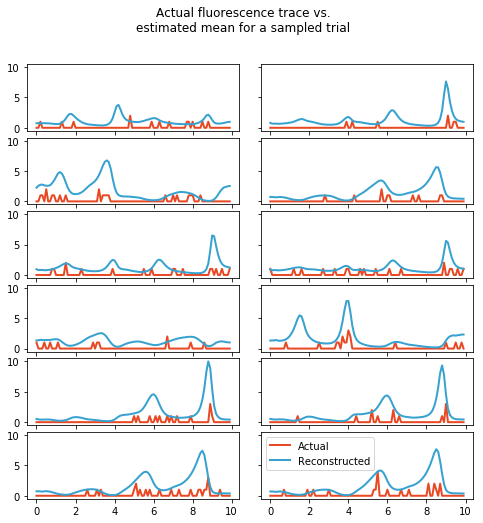

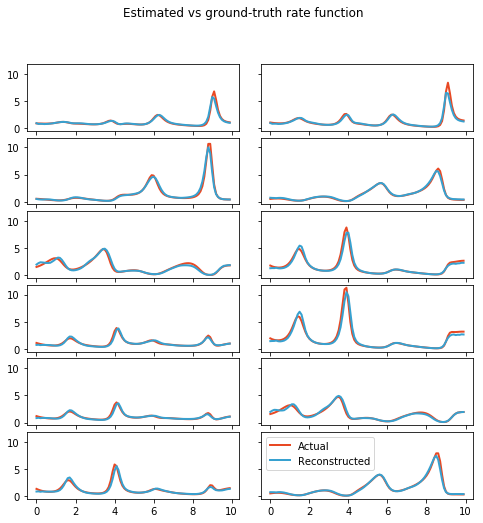

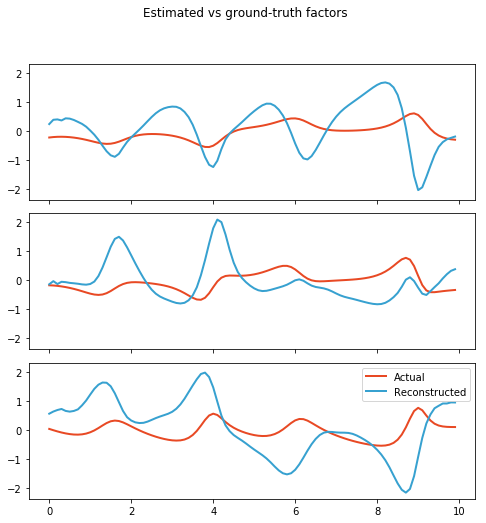

In [8]:
fig_dict = model.plot_summary(data=valid_data, truth=valid_truth)

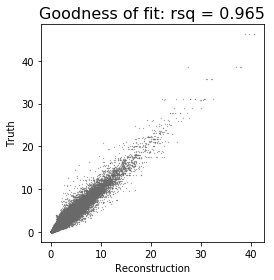

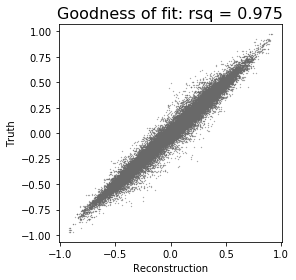

In [9]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)

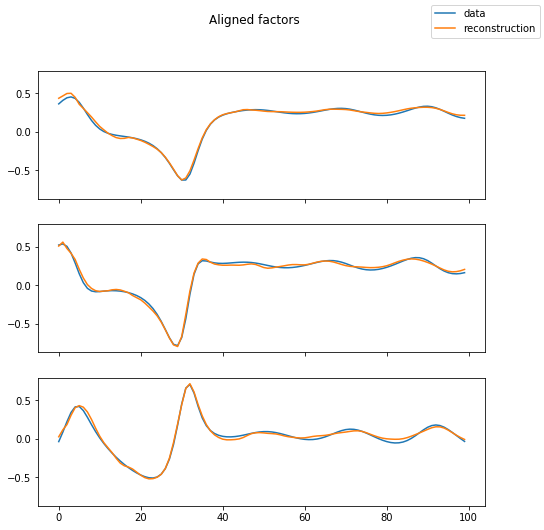

In [10]:
fig, axs = plt.subplots(figsize=(8,8), nrows=3, ncols=1, sharex=True, sharey=True)
for ix in range(3):
    plt.sca(axs[ix])
    plt.plot(data_dict['valid_latent'][0, :100, ix])
    plt.plot(results_dict['factors']['aligned'][:100, ix])
    
fig.suptitle('Aligned factors')
fig.legend(['data', 'reconstruction'])

## Inspecting trained model 

In [3]:
seed = 250
if os.path.exists('./synth_data/lorenz_%s'%seed):
    data_dict = read_data('./synth_data/lorenz_%s'%seed)
else:
    from synthetic_data import generate_lorenz_data
    param_dict = yaml.load(open('./synth_data/lorenz_params.yaml', 'r'), Loader=yaml.FullLoader)
    data_dict = generate_lorenz_data(N_cells=param_dict['cells'],
                                     N_inits=param_dict['inits'],
                                     N_trials=param_dict['trials'],
                                     N_steps=param_dict['steps'],
                                     N_stepsinbin=param_dict['steps_in_bin'],
                                     dt_lorenz=param_dict['dt_sys'],
                                     dt_spike = param_dict['dt_spike'],
                                     base_firing_rate= param_dict['rate_scale'],
                                     save=True,
                                     seed=250)

# For spike data
train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = {'rates'  : data_dict['train_rates'],
               'latent' : data_dict['train_latent']}

valid_truth = {'rates'  : data_dict['valid_rates'],
               'latent' : data_dict['valid_latent']}

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape;
print(train_data.shape);
print('Number of datapoints = %s'%train_data.numel())

Generating Lorenz data
Converting to rates and spikes


/home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")
/home/luke/anaconda2/envs/pytorch04/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Converting to fluorescence
Train and test split
Saving to .//synth_data/lorenz_250
Saving variable with name:  train_fluor
Saving variable with name:  valid_calcium
Saving variable with name:  train_spikes
Saving variable with name:  valid_latent
Saving variable with name:  dt
Saving variable with name:  valid_truth
Saving variable with name:  train_calcium
Saving variable with name:  valid_fluor
Saving variable with name:  train_latent
Saving variable with name:  cell_loc
Saving variable with name:  valid_rates
Saving variable with name:  valid_data
Saving variable with name:  train_rates
Saving variable with name:  valid_oasis
Saving variable with name:  loading_weights
Saving variable with name:  train_data
Saving variable with name:  cells
Saving variable with name:  train_oasis
Saving variable with name:  train_truth
Saving variable with name:  valid_spikes
Saving variable with name:  conversion_factor
torch.Size([1040, 100, 30])
Number of datapoints = 3120000


In [4]:
hyperparams = load_parameters('parameters/parameters_lorenz_spikes.yaml')
hyperparams['run_name'] = 'poisson_seed250_f3_g164_eg164_u0_191118'
model = LFADS(inputs_dim = num_cells, T = num_steps, dt = float(data_dict['dt']), device=device,
              model_hyperparams=hyperparams).to(device)

Random seed: 2448


In [5]:
model.load_checkpoint('best')
model.epochs

1374

{'ix': 380,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth_factors': <Figure size 576x576 with 3 Axes>,
 'truth_rates': <Figure size 576x576 with 12 Axes>}

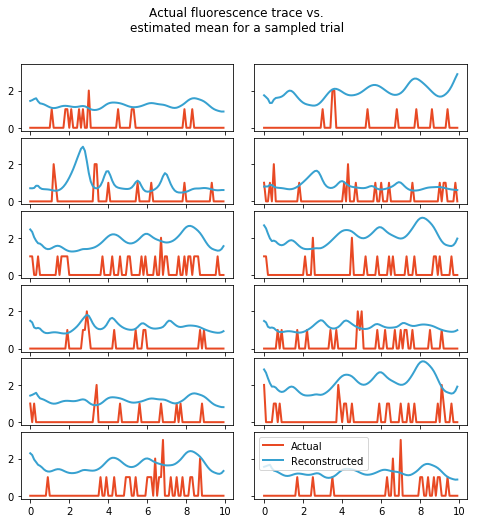

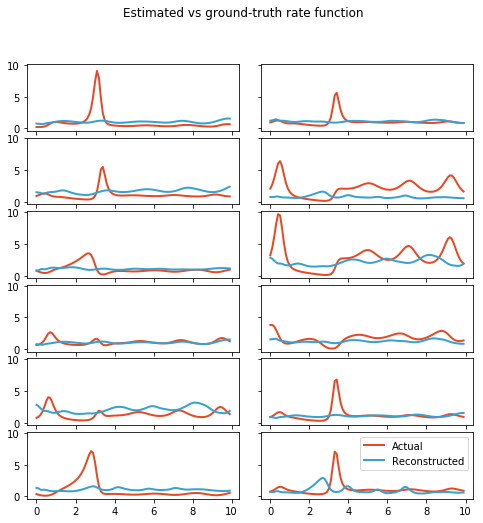

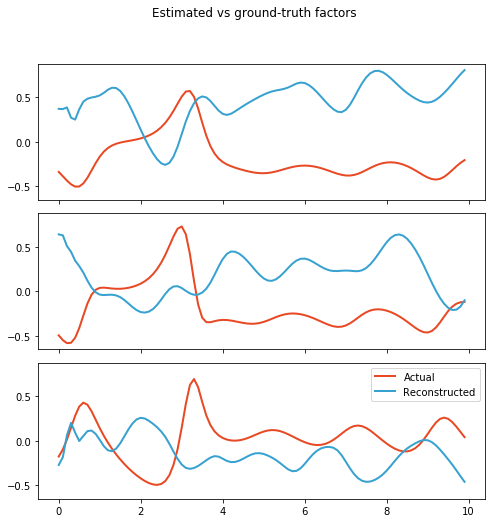

In [6]:
model.plot_summary(train_data, train_truth)

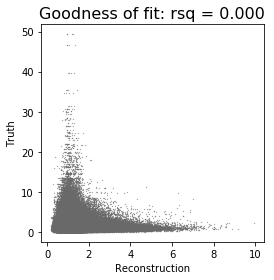

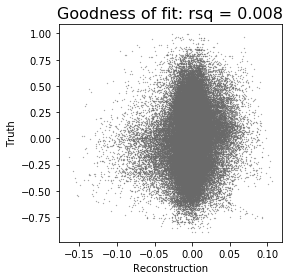

In [8]:
results_dict = model.plot_recon_rsquared(valid_data, valid_truth, train_data, train_truth)